# Redspots Environment

## Environment Description

A simple gridworld with white (safe) spots, green (rewarding) spots, and red (undesirable/dangerous) spots.

## Goal

Have an agent map the environment and infer the best way to avoid red spots and get to the green spot.

# Setup

## Imports

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.cm as cm

import seaborn as sns

import pymdp
from pymdp import utils
from coppeliasim_zmqremoteapi_client import RemoteAPIClient
import numpy as np
import time
from math import comb
import random

client = RemoteAPIClient()
sim = client.getObject('sim')

## Initialize Coppelia Environment

In [3]:
num_obstacles = 0
def move_to_grid(x, y):
    '''Moves coppelia coordinates (x,y) to a 40x40 grid, z coordinate remains constant, outputs coordinate in terms of grid'''
    
    # Translate x,y coordinate 2.5 up and 2.5 right
    x = x + 2.5
    y = y + 2.5
    
    # Ensure coordinates (x,y) are within (0,0) and (5,5)
    if x > 5 or x < 0:
        return "Invalid x coordinate!"
    elif y > 5 or y < 0:
        return "Invalid y coordinate!"
    
    # Convert x, y to grid indices by dividing by 0.125 (since each grid cell is 0.125 wide)
    x_grid = round(x / 0.125)
    y_grid = round(y / 0.125)
    
    # Ensure that the coordinates are within valid grid range (0 to 40)
    if x_grid > 40 or x_grid < 0:
        return "Invalid x grid point!"
    if y_grid > 40 or y_grid < 0:
        return "Invalid y grid point!"
    
    # Return the grid indices
    return (x_grid, y_grid)

    
def grid_to_coordinates(x_grid, y_grid):
    '''Converts a valid 40x40 grid point back into coppelia (x,y,z) coordinates in the range (x,y) = (0,0)-(5,5), z remains constant'''
    # Ensure the grid points are within valid range (0 to 40)
    if x_grid > 40 or x_grid < 0:
        return "Invalid x grid point!"
    if y_grid > 40 or y_grid < 0:
        return "Invalid y grid point!"
    
    # Reverse the grid index conversion by multiplying by 0.125
    x = x_grid * 0.125
    y = y_grid * 0.125
    
    x = x-2.5
    y = y-2.5
    # Return the original (x, y, z) coordinates
    return (x, y, 0.05)   

def get_object_position(object_name):
    # Step 2: Get the object handle by name
    objectHandle = sim.getObject(f'/{object_name}')
    
    if objectHandle == -1:
        raise Exception(f"Object '{object_name}' not found.")
    
    # Step 3: Get the position of the obstacle relative to the world (-1 means world reference)
    objectPosition = sim.getObjectPosition(objectHandle, -1)
    
    # Round each element in the position to the nearest thousandth
    roundedPosition = [round(coord, 3) for coord in objectPosition]
    
    print(f"Coppelia position of {object_name}: {roundedPosition}")
    return roundedPosition

def create_bounding_locations(position, dimensions):
    """
    Creates bounding locations for an object.
    
    Parameters:
    -----------
    position : tuple (x, y)
        Center position of the object
    dimensions : tuple (a, b, c)
        Dimensions of the object (width, depth, height)
        
    Returns:
    --------
    tuple
        Eight points: (top_right, bottom_left, top_left, bottom_right, mid_top, mid_bottom, mid_left, mid_right)
    """
    (x, y) = position
    (a, b, c) = dimensions

    # Bounding locations
    top_right = (x + a/2, y + b/2)
    bottom_left = (x - a/2, y - b/2)
    top_left = (x - a/2, y + b/2)
    bottom_right = (x + a/2, y - b/2)

    # Midpoints
    mid_top = ((top_right[0] + top_left[0]) / 2, (top_right[1] + top_left[1]) / 2)
    mid_bottom = ((bottom_right[0] + bottom_left[0]) / 2, (bottom_right[1] + bottom_left[1]) / 2)
    mid_left = ((top_left[0] + bottom_left[0]) / 2, (top_left[1] + bottom_left[1]) / 2)
    mid_right = ((top_right[0] + bottom_right[0]) / 2, (top_right[1] + bottom_right[1]) / 2)
    
    return top_right, bottom_left, top_left, bottom_right, mid_top, mid_bottom, mid_left, mid_right

def get_all_grid_points_in_obstacle(position, dimensions):
    """
    Get all grid points with 0.125 interval within an obstacle.
    
    Parameters:
    -----------
    position : tuple (x, y)
        Center position of the obstacle
    dimensions : tuple (a, b, c)
        Dimensions of the obstacle (width, depth, height)
        
    Returns:
    --------
    list
        All grid points with 0.125 interval that are contained within the obstacle
    """
    (x, y) = position
    (a, b, c) = dimensions
    
    # Calculate the boundaries
    x_min = x - a/2
    x_max = x + a/2
    y_min = y - b/2
    y_max = y + b/2
    
    # Adding a small epsilon to ensure we include boundary points
    epsilon = 0.0001
    
    # Find the closest grid points that contain the obstacle
    x_start = math.ceil(x_min / 0.125) * 0.125
    x_end = math.floor(x_max / 0.125) * 0.125
    y_start = math.ceil(y_min / 0.125) * 0.125
    y_end = math.floor(y_max / 0.125) * 0.125
    
    # Generate all grid points within the obstacle
    all_grid_points = []
    current_x = x_start
    while current_x <= x_end + epsilon:
        current_y = y_start
        while current_y <= y_end + epsilon:
            all_grid_points.append((round(current_x, 3), round(current_y, 3)))
            current_y += 0.125
        current_x += 0.125
    
    return all_grid_points

        
def check_bounds(loc):
    '''Checks if a location is within the bounds of the grid'''
    
    x, y, z = loc
    if x > 5 or x < 0:
        return None
    elif y > 5 or y < 0:
        return None
    else:
        return loc


def create_cuboid(dimensions, position, orientation=None, color=None, mass=0, respondable=False, name="cuboid"):
    """
    Create a cuboid in CoppeliaSim with customizable properties using the ZMQ Remote API.
    
    Parameters:
    -----------
    dimensions : list/tuple
        [x, y, z] dimensions of the cuboid in meters
    position : list/tuple
        [x, y, z] position coordinates of the cuboid
    orientation : list/tuple, optional
        [alpha, beta, gamma] orientation in Euler angles (radians)
    color : list/tuple, optional
        [r, g, b] color components (0-1 range)
    mass : float, optional
        Mass of the cuboid in kg (0 = static object)
    respondable : bool, optional
        Whether the cuboid should be respondable (participate in dynamics)
    name : str, optional
        Name of the cuboid object
        
    Returns:
    --------
    int
        Handle to the created cuboid object
    """
    # Default orientation if none specified
    if orientation is None:
        orientation = [0, 0, 0]
    
    # Set the options flag based on parameters
    options = 0
    if respondable:
        options = options | 8  # bit 3 (8) = respondable
    
    # Create the cuboid primitive
    cuboid_handle = sim.createPrimitiveShape(
        sim.primitiveshape_cuboid,  # shape type
        dimensions,  # size parameters [x, y, z]
        options  # options
    )
    
    # Set object name
    sim.setObjectAlias(cuboid_handle, name)
    
    # Set position
    sim.setObjectPosition(cuboid_handle, -1, position)
    
    # Set orientation
    sim.setObjectOrientation(cuboid_handle, -1, orientation)
    
    # Set mass if it's a dynamic object
    if mass > 0:
        sim.setShapeMass(cuboid_handle, mass)
    
    # Set color if specified
    if color is not None:
        # In the new API, we can set the color directly on the shape
        sim.setShapeColor(cuboid_handle, None, 0, color)  # 0 = ambient/diffuse color component
    
    return cuboid_handle



redspots = []
# Random positional value between 0+dim[index of coordinate(x = 0,y=1)] and 5-dim[index of coordinate]
def initialize_environment(seed):
    global num_obstacles  # Declare we're using the global variable
    random.seed(seed)
    num_obstacles = random.randint(20, 50)
    print(f"Initializing environment with seed {seed} and {num_obstacles} obstacles")
    obstacle_positions = []
    obstacle_handles = []
    obstacle_dimensions = [0.3, 0.3, 0.8]  # Same dimensions for all obstacles
    
    # Function to check if a new position conflicts with existing obstacles
    def is_position_valid(new_x, new_y, object_dimensions):
        # Convert position and dimensions to format needed for bounding locations
        new_position = (new_x, new_y)
        
        # Get bounding points for the new obstacle
        new_bounds = create_bounding_locations(new_position, object_dimensions)
        new_top_right, new_bottom_left, _, _, _, _, _, _ = new_bounds
        
        # Check if the new obstacle would be inside the room bounds
        if (new_x + object_dimensions[0]/2 > 2.5 or 
            new_x - object_dimensions[0]/2 < -2.5 or
            new_y + object_dimensions[1]/2 > 2.5 or
            new_y - object_dimensions[1]/2 < -2.5):
            return False
        
        # Check against all existing obstacles
        for pos in obstacle_positions:
            existing_x, existing_y = pos[0], pos[1]
            existing_position = (existing_x, existing_y)
            
            # Get bounding points for existing obstacle
            existing_bounds = create_bounding_locations(existing_position, obstacle_dimensions)
            existing_top_right, existing_bottom_left, _, _, _, _, _, _ = existing_bounds
            
            # Check for overlap using AABB collision detection
            # If one rectangle is to the left of the other
            if (new_top_right[0] < existing_bottom_left[0] or 
                existing_top_right[0] < new_bottom_left[0]):
                continue
                
            # If one rectangle is above the other
            if (new_top_right[1] < existing_bottom_left[1] or 
                existing_top_right[1] < new_bottom_left[1]):
                continue
                
            # If we get here, the rectangles overlap
            return False
            
        # If we've checked all obstacles and found no overlaps
        return True
    
    # Create obstacles
    for i in range(num_obstacles):
        # Try to find a valid position (up to 100 attempts)
        valid_position = False
        attempts = 0
        
        while not valid_position and attempts < 100:
            # Generate random position that aligns with the 0.125 grid
            # Calculate the range in grid units
            min_grid_x = int((-2.5 + (obstacle_dimensions[0]/2 + 0.1)) / 0.125)
            max_grid_x = int((2.5 - (obstacle_dimensions[0]/2 + 0.1)) / 0.125)
            min_grid_y = int((-2.5 + (obstacle_dimensions[1]/2 + 0.1)) / 0.125)
            max_grid_y = int((2.5 - (obstacle_dimensions[1]/2 + 0.1)) / 0.125)
            
            # Generate random grid positions
            grid_x = random.randint(min_grid_x, max_grid_x)
            grid_y = random.randint(min_grid_y, max_grid_y)
            
            # Convert back to Coppelia coordinates
            x = grid_x * 0.125
            y = grid_y * 0.125
            
            # Check if this position is valid
            valid_position = is_position_valid(x, y, obstacle_dimensions)
            attempts += 1
            
        if valid_position:
            # Add position to our list
            obstacle_positions.append((x, y))
            
            # Create the obstacle
            obstacle = create_cuboid(
                dimensions=obstacle_dimensions,
                position=[x, y, 0.4],  # z=0.4 is half the height
                orientation=[0, 0, 0],
                color=[1, 0, 0],
                mass=1,
                respondable=True,
                name=f"Obstacle{i}"
            )
            
            obstacle_handles.append(obstacle)
            print(f"Created Obstacle{i} at position [{x}, {y}, 0.4]")
        else:
            print(f"Could not find valid position for Obstacle{i} after {attempts} attempts")
    
    # Now create the single flat object with dimensions [0.125, 0.125, 0.01]
    flat_object_dimensions = [0.125, 0.125, 0.01]
    valid_position = False
    attempts = 0
    goal_position = None
    goal_handle = None
    
    while not valid_position and attempts < 100:
        # Generate random position that aligns with the 0.125 grid
        min_grid_x = int((-2.5 + (flat_object_dimensions[0]/2 + 0.1)) / 0.125)
        max_grid_x = int((2.5 - (flat_object_dimensions[0]/2 + 0.1)) / 0.125)
        min_grid_y = int((-2.5 + (flat_object_dimensions[1]/2 + 0.1)) / 0.125)
        max_grid_y = int((2.5 - (flat_object_dimensions[1]/2 + 0.1)) / 0.125)
        
        # Generate random grid positions
        grid_x = random.randint(min_grid_x, max_grid_x)
        grid_y = random.randint(min_grid_y, max_grid_y)
        
        # Convert back to Coppelia coordinates
        x = grid_x * 0.125
        y = grid_y * 0.125
        
        # Check if this position is valid
        valid_position = is_position_valid(x, y, flat_object_dimensions)
        attempts += 1
        
    if valid_position:
        # Create the flat object (z=0.005 is half the height of 0.01)
        goal_handle = create_cuboid(
            dimensions=flat_object_dimensions,
            position=[x, y, 0.005],  
            orientation=[0, 0, 0],
            color=[0, 1, 0],  # Green to distinguish from obstacles
            mass=0.1,
            respondable=True,
            name="Goal_Loc"  # Renamed as requested
        )
        
        goal_position = (x, y, 0.005)
        print(f"Created Goal_Loc at position [{x}, {y}, 0.005]")
    else:
        print(f"Could not find valid position for Goal_Loc after {attempts} attempts")
    
    # Now place bubbleRob at a random position with no overlap
    # First, collect all positions to avoid (obstacles and goal)
    all_positions = obstacle_positions.copy()
    if goal_position:
        all_positions.append((goal_position[0], goal_position[1]))  # Only need x,y from goal
    
    # Estimate bubbleRob dimensions (assuming it's roughly 0.2 x 0.2)
    bubbleRob_dimensions = [0.2, 0.2, 0.2]  # Approximate dimensions
    
    valid_position = False
    attempts = 0
    bubbleRob_position = None
    
    # Function to check if bubbleRob position is valid
    def is_bubbleRob_position_valid(new_x, new_y):
        # Check if within bounds (-2 to 2 as specified)
        if new_x > 2 or new_x < -2 or new_y > 2 or new_y < -2:
            return False
        
        # Create bubbleRob position and bounds
        new_position = (new_x, new_y)
        new_bounds = create_bounding_locations(new_position, bubbleRob_dimensions)
        new_top_right, new_bottom_left, _, _, _, _, _, _ = new_bounds
        
        # Check against obstacles
        for i, pos in enumerate(obstacle_positions):
            existing_x, existing_y = pos[0], pos[1]
            existing_position = (existing_x, existing_y)
            
            # Get bounding points for existing obstacle
            existing_bounds = create_bounding_locations(existing_position, obstacle_dimensions)
            existing_top_right, existing_bottom_left, _, _, _, _, _, _ = existing_bounds
            
            # Check for overlap using AABB collision detection
            if not (new_top_right[0] < existing_bottom_left[0] or 
                    existing_top_right[0] < new_bottom_left[0] or
                    new_top_right[1] < existing_bottom_left[1] or 
                    existing_top_right[1] < new_bottom_left[1]):
                # Overlap detected
                return False
                
        # Check against goal if it exists
        if goal_position:
            goal_x, goal_y = goal_position[0], goal_position[1]
            goal_pos = (goal_x, goal_y)
            
            # Get bounding points for goal
            goal_bounds = create_bounding_locations(goal_pos, flat_object_dimensions)
            goal_top_right, goal_bottom_left, _, _, _, _, _, _ = goal_bounds
            
            # Check for overlap with goal
            if not (new_top_right[0] < goal_bottom_left[0] or 
                    goal_top_right[0] < new_bottom_left[0] or
                    new_top_right[1] < goal_bottom_left[1] or 
                    goal_top_right[1] < new_bottom_left[1]):
                # Overlap detected
                return False
        
        # If we get here, position is valid
        return True
    
    while not valid_position and attempts < 100:
        # Generate random position that aligns with the 0.125 grid
        min_grid_x = int((-2.0 + (bubbleRob_dimensions[0]/2)) / 0.125)
        max_grid_x = int((2.0 - (bubbleRob_dimensions[0]/2)) / 0.125)
        min_grid_y = int((-2.0 + (bubbleRob_dimensions[1]/2)) / 0.125)
        max_grid_y = int((2.0 - (bubbleRob_dimensions[1]/2)) / 0.125)
        
        # Generate random grid positions
        grid_x = random.randint(min_grid_x, max_grid_x)
        grid_y = random.randint(min_grid_y, max_grid_y)
        
        # Convert back to Coppelia coordinates
        x = grid_x * 0.125
        y = grid_y * 0.125
        
        # Check if this position is valid
        valid_position = is_bubbleRob_position_valid(x, y)
        attempts += 1
    
    if valid_position:
        # Get the handle for bubbleRob
        try:
            bubbleRob_handle = sim.getObject('/bubbleRob')
            if bubbleRob_handle != -1:  # -1 means object not found
                # Set bubbleRob position (z=0.12 as in the original code)
                sim.setObjectPosition(bubbleRob_handle, -1, [x, y, 0.12])
                bubbleRob_position = (x, y, 0.12)
                print(f"Placed bubbleRob at position [{x}, {y}, 0.12]")
            else:
                print("bubbleRob object not found in the scene!")
        except Exception as e:
            print(f"Error placing bubbleRob: {e}")
    else:
        print(f"Could not find valid position for bubbleRob after {attempts} attempts")
    
    # Return all obstacle positions as a flat list: [x1, y1, x2, y2, ...] and other positions
    flat_positions = []
    for pos in obstacle_positions:
        flat_positions.extend(pos)
    
    # Process obstacles to collect redspots (grid points covered by obstacles)
    for obstacle_num in range(num_obstacles):
        obstacle_name = f'Obstacle{obstacle_num}'
   
        try:
            # Get position for the current obstacle
            obstacle_position_list = get_object_position(obstacle_name)
            obstacle_position = (obstacle_position_list[0], obstacle_position_list[1])
            
            # Using the same dimensions for all obstacles as defined in initialize_environment
            obstacle_dimensions = (0.3, 0.3, 0.8)  # Match the dimensions from initialize_environment
            
            print(f"Processing {obstacle_name}...")
            
            # Get all grid points within this obstacle at 0.125 intervals
            grid_points_in_obstacle = get_all_grid_points_in_obstacle(obstacle_position, obstacle_dimensions)
            
            # Convert each Coppelia coordinate to grid coordinates
            for point in grid_points_in_obstacle:
                x, y = point
                grid_position = move_to_grid(x, y)
                
                # Only append valid grid positions
                if isinstance(grid_position, tuple):
                    # Check if this grid position is already in redspots (avoid duplicates)
                    if grid_position not in redspots:
                        redspots.append(grid_position)
                else:
                    print(f"Warning: Invalid grid position for {obstacle_name} at {point}: {grid_position}")
                
        except Exception as e:
            print(f"Error processing {obstacle_name}: {e}")

    print(f"Total redspots collected: {len(redspots)}")
    print("Redspots:", redspots)
    return flat_positions, goal_position, obstacle_handles, goal_handle, bubbleRob_position


def clear_environment(obstacle_handles=None, goal_handle=None):
    """
    Clear all cuboids created by the initialize_environment function
    
    Parameters:
    -----------
    obstacle_handles : list, optional
        List of handles to obstacle objects
    goal_handle : int, optional
        Handle to the goal location object
    
    Returns:
    --------
    bool
        True if all objects were successfully removed
    """
    global num_obstacles  # Declare we're using the global variable
    success = True
    
    # Remove all obstacles if handles are provided
    if obstacle_handles:
        for i, handle in enumerate(obstacle_handles):
            try:
                if sim.isHandle(handle):  # Check if handle is valid
                    sim.removeObject(handle)
                    print(f"Removed Obstacle{i}")
            except Exception as e:
                print(f"Error removing Obstacle{i}: {e}")
                success = False
    
    # Remove goal location if handle is provided
    if goal_handle:
        try:
            if sim.isHandle(goal_handle):  # Check if handle is valid
                sim.removeObject(goal_handle)
                print("Removed Goal_Loc")
        except Exception as e:
            print(f"Error removing Goal_Loc: {e}")
            success = False
    
    # Alternative method: try to remove all objects by name
    # This is useful if handles are not available
    if not obstacle_handles and not goal_handle:
        # Try to remove obstacles by name
        for i in range(num_obstacles):  # Fixed the range to use the global variable
            try:
                object_handle = sim.getObject(f'/Obstacle{i}')
                if object_handle != -1:
                    sim.removeObject(object_handle)
                    print(f"Removed Obstacle{i} by name")
            except Exception as e:
                print(f"Error removing Obstacle{i} by name: {e}")
                success = False
        
        # Try to remove goal by name
        try:
            goal_object = sim.getObject('/Goal_Loc')
            if goal_object != -1:
                sim.removeObject(goal_object)
                print("Removed Goal_Loc by name")
        except Exception as e:
            print(f"Error removing Goal_Loc by name: {e}")
            success = False
    
    return success

trial_number = 1
initialize_environment(trial_number)

agent_pos = move_to_grid(get_object_position('bubbleRob')[0], get_object_position('bubbleRob')[1])
goal_location = move_to_grid(get_object_position('Goal_Loc')[0], get_object_position('Goal_Loc')[1])


Initializing environment with seed 1 and 24 obstacles
Created Obstacle0 at position [2.25, -1.75, 0.4]
Created Obstacle1 at position [-0.25, -1.375, 0.4]
Created Obstacle2 at position [1.625, 1.25, 0.4]
Created Obstacle3 at position [1.5, 0.75, 0.4]
Created Obstacle4 at position [-0.625, -1.5, 0.4]
Created Obstacle5 at position [1.625, -2.125, 0.4]
Created Obstacle6 at position [0.75, 1.125, 0.4]
Created Obstacle7 at position [-2.25, 1.25, 0.4]
Created Obstacle8 at position [-0.125, -0.5, 0.4]
Created Obstacle9 at position [-1.5, 0.25, 0.4]
Created Obstacle10 at position [-2.125, -2.125, 0.4]
Created Obstacle11 at position [-2.125, 2.0, 0.4]
Created Obstacle12 at position [-2.25, 0.75, 0.4]
Created Obstacle13 at position [-0.625, 1.125, 0.4]
Created Obstacle14 at position [1.625, 2.125, 0.4]
Created Obstacle15 at position [-0.5, 0.5, 0.4]
Created Obstacle16 at position [-0.5, -0.5, 0.4]
Created Obstacle17 at position [1.375, 0.0, 0.4]
Created Obstacle18 at position [-0.875, 0.0, 0.4]
C

## Auxilary Functions

In [4]:
def plot_grid(grid_locations, num_x = 3, num_y = 3 ):
    """
    Plots the spatial coordinates of GridWorld as a heatmap, with each (X, Y) coordinate 
    labeled with its linear index (its `state id`)
    """

    grid_heatmap = np.zeros((num_x, num_y))
    for linear_idx, location in enumerate(grid_locations):
      y, x = location
      grid_heatmap[y, x] = linear_idx
    sns.set(font_scale=1.5)
    sns.heatmap(grid_heatmap, annot=True, cbar = False, fmt='.0f', cmap='crest')

def plot_likelihood(matrix, title_str = "Likelihood distribution (A)"):
    """
    Plots a 2-D likelihood matrix as a heatmap
    """

    if not np.isclose(matrix.sum(axis=0), 1.0).all():
      raise ValueError("Distribution not column-normalized! Please normalize (ensure matrix.sum(axis=0) == 1.0 for all columns)")
    
    fig = plt.figure(figsize = (6,6))
    ax = sns.heatmap(matrix, cmap = 'gray', cbar = False, vmin = 0.0, vmax = 1.0)
    plt.title(title_str)
    plt.show()


def plot_beliefs(belief_dist, title_str=""):
    """
    Plot a categorical distribution or belief distribution, stored in the 1-D numpy vector `belief_dist`
    """

    if not np.isclose(belief_dist.sum(), 1.0):
      raise ValueError("Distribution not normalized! Please normalize")

    plt.grid(zorder=0)
    plt.bar(range(belief_dist.shape[0]), belief_dist, color='r', zorder=3)
    plt.xticks(range(belief_dist.shape[0]))
    plt.title(title_str)
    plt.show()

def add_noise(matrix, noise_level=0.1):
    """
    Add noise to transition matrix while preserving normalization
    
    Args:
        A: Original transition matrix
        noise_level: Amount of noise to add (0-1)
    """
    # Generate random noise
    noise = np.random.uniform(-noise_level, noise_level, size=matrix.shape)

    print(noise) 
    
    # Add noise to matrix
    noisy_matrix = matrix + noise
    
    # Ensure non-negative
    noisy_matrix = np.maximum(noisy_matrix, 0.0)
    
    # Normalize columns to sum to 1
    noisy_matrix = noisy_matrix / noisy_matrix.sum(axis=0, keepdims=True)
    
    return noisy_matrix




## Parameters

### Grid

In [5]:
# grid_dimensions
grid_dims = [40, 40]

# list of grid positiions
grid_locations = []
for i in range(grid_dims[0]):
    for j in range(grid_dims[1]):
        grid_locations.append((i,j))

In [6]:
# start point
agent_pos = move_to_grid(get_object_position('bubbleRob')[0],get_object_position('bubbleRob')[1])

# end goal
goal_location = move_to_grid(get_object_position('Goal_Loc')[0],get_object_position('Goal_Loc')[1])
print(agent_pos)
print(goal_location)

Coppelia position of bubbleRob: [0.25, 1.625, 0.12]
Coppelia position of bubbleRob: [0.25, 1.625, 0.12]
Coppelia position of Goal_Loc: [-0.875, 0.625, 0.005]
Coppelia position of Goal_Loc: [-0.875, 0.625, 0.005]
(22, 33)
(13, 25)


## Generative Model

### States & Observations

s1 = current location \
s2 = attribute of current location

o1 = observed current location \
o2 = color of current location

In [7]:
# s1 is already defined = grid_locations

# s2
current_attribute = ['SAFE', 'DANGER', 'REWARDING']

# list of # of possibillities for states
num_states = [len(grid_locations), len(current_attribute)] # location

In [8]:
# o1 is already defined = grid_locatioons

# o2
current_color = ['WHITE', 'RED', 'GREEN']

# list of # of possibilities for observations
num_obs = [len(grid_locations), len(current_color)]

# Generative Model

## Agent's Observation Matrix

In [9]:
vision_matrix = np.zeros((num_states[0], num_states[1]))

# Rule-based assignment
for loc in range(num_states[0]):
    # Example: Assume all locations have [SAFE: 0.7, DANGER: 0.2, REWARDING: 0.1]
    vision_matrix[loc] = np.array([0.33, 0.33, 0.33])
    vision_matrix[loc] /= vision_matrix[loc].sum()

    # Normalize each location's attribute distribution (ensure sum = 1)

vision_matrix

array([[0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333],
       ...,
       [0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333]])

In [10]:
def update_vision_matrix(vision_matrix, obs):
    """
    Update the observation matrix based on an observation
    """

    one_hot_obs = [0,0,0]
    one_hot_obs[obs[1]] = 1
    vision_matrix[obs[0]] = one_hot_obs

    return vision_matrix

In [11]:
def visualize_vision_matrix(vision_matrix, grid_dims=grid_dims):
    """
    Visualizes the observation matrix as three separate heatmaps, one for each attribute
    (SAFE, DANGER, REWARDING)
    
    Args:
        vision_matrix: numpy array of shape (num_locations, num_attributes)
        grid_dims: list of [height, width] of the grid
    """
    # Create figure with three subplots
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Labels for each subplot
    titles = ['SAFE', 'DANGER', 'REWARDING']
    
    for idx, title in enumerate(titles):
        # Reshape the matrix to match grid dimensions
        heatmap_data = vision_matrix[:, idx].reshape(grid_dims[0], grid_dims[1])
        
        # Plot heatmap
        sns.heatmap(heatmap_data, 
                   ax=axes[idx], 
                   cmap='YlOrRd',
                   vmin=0, 
                   vmax=1,
                   annot=True,
                   fmt='.2f')
        
        axes[idx].set_title(f'{title} Probability')
        axes[idx].set_xlabel('Y coordinate')
        axes[idx].set_ylabel('X coordinate')
    
    plt.tight_layout()
    plt.show()

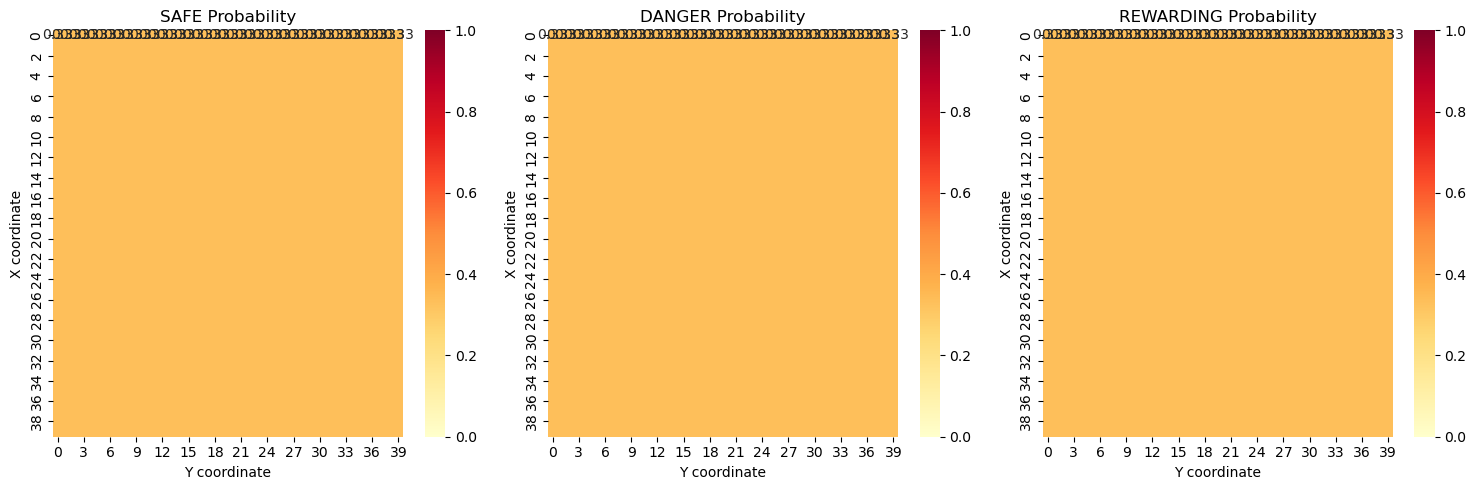

In [12]:
visualize_vision_matrix(vision_matrix, grid_dims)

## A Matrix

In [13]:
# Define A Matrix
A_shapes = []
for i in num_obs:
    A_shapes.append([i] + num_states)

A = utils.obj_array_zeros(A_shapes)
A.shape, A_shapes

((2,), [[1600, 1600, 3], [3, 1600, 3]])

### Location Observation Modality A[0]

In [14]:
A[0] = np.zeros(A_shapes[0])  # Initialize with zeros

# Fill in the observation mapping for each safety level
for safety_level in range(num_states[1]):
    A[0][:,:,safety_level] = np.eye(num_states[0])  # Copy the identity matrix for each safety level

# Verify the shape and normalization
print("New A[0] shape:", A[0].shape)
print("Column sums:", A[0].sum(axis=0).sum(axis=1))  # Should be all 1's

New A[0] shape: (1600, 1600, 3)
Column sums: [3. 3. 3. ... 3. 3. 3.]


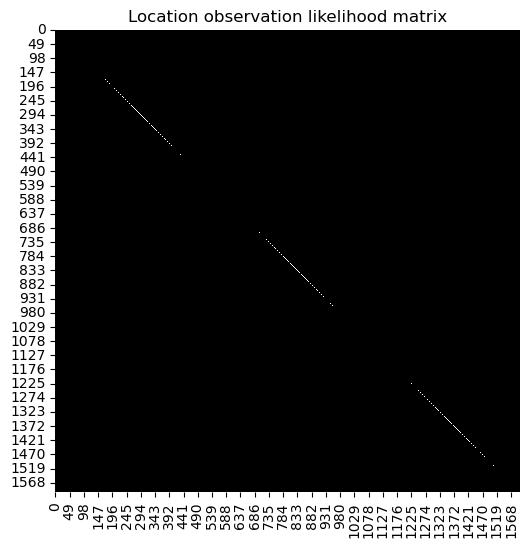

In [15]:
# Extract a 2D slice by fixing the safety level dimension to 0
import numpy as np
plot_likelihood(A[0][:, :, 0], "Location observation likelihood matrix")

### Color observation modality: A[1]

In [16]:
# Map safety levels to indices
safety_level_to_index = {state: i for i, state in enumerate(current_attribute)}  # {'SAFE': 0, 'DANGER': 1, 'REWARDING': 2}

# Probabilities for each color given the safety level (in correct heatmap order: RED, GREEN, WHITE)
probabilities = {
    "SAFE": [1, 0, 0],        # ['WHITE', 'RED', 'GREEN']
    "DANGER": [0, 1, 0.],      # ['WHITE', 'RED', 'GREEN']
    "REWARDING": [0, 0, 1]    # ['WHITE', 'RED', 'GREEN']
}

In [17]:
# Populate A[1]
for safety_level, probs in probabilities.items():
    safety_idx = safety_level_to_index[safety_level]
    for loc in range(len(grid_locations)):  # Iterate over grid locations
        for color_idx, prob in enumerate(probs):  # Iterate over colors (RED, GREEN, WHITE)
            A[1][color_idx, loc, safety_idx] = prob  # Assign probabilities

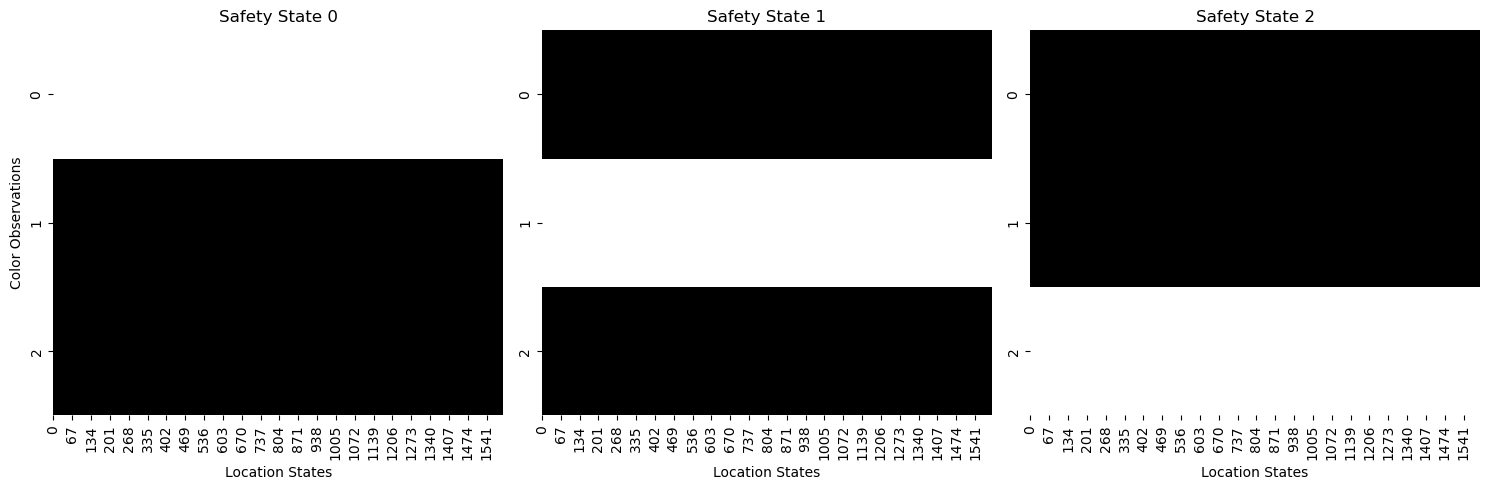

In [18]:
# Create a figure with 3 subplots (one for each safety state)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Extract and plot each safety state slice
for safety_idx in range(3):
    # Get a slice for the current safety state (fixing all other dimensions to 0)
    slice_matrix = A[1][:, :, safety_idx]
    
    # Plot the slice
    sns.heatmap(slice_matrix, ax=axes[safety_idx], cmap='gray', cbar=False, vmin=0.0, vmax=1.0)
    axes[safety_idx].set_title(f'Safety State {safety_idx}')
    axes[safety_idx].set_xlabel('Location States')
    if safety_idx == 0:
        axes[safety_idx].set_ylabel('Color Observations')

plt.tight_layout()
plt.show()

### Add Noise

In [19]:
# Add noise to each modality separately
for modality in range(len(A)):
    A[modality] = add_noise(A[modality], noise_level=0)

[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]]
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]]


### Plot Each Matrix

## B Matrix

### Define Shape

In [20]:
num_controls = [5, 1]
B_f_shapes = [ [ns, ns, num_controls[f]] for f, ns in enumerate(num_states)]
B = utils.obj_array_zeros(B_f_shapes)
B_f_shapes

[[1600, 1600, 5], [3, 3, 1]]

### B[0] - Control Factor - Location Transitions

In [21]:
grid_dims

[40, 40]

In [22]:
actions = ["UP", "DOWN", "LEFT", "RIGHT", "STAY"]

In [23]:
for action_id, action_label in enumerate(actions):
  
    for curr_state, (x, y) in enumerate(grid_locations):
        
        # Calculate next position based on action
        if action_label == "UP":
            next_y = max(0, y - 1)        # Move up (decrease y)
            next_x = x
        elif action_label == "DOWN":
            next_y = min(grid_dims[1]-1, y + 1)  # Move down (increase y)
            next_x = x
        elif action_label == "LEFT":
            next_x = max(0, x - 1)        # Move left (decrease x)
            next_y = y
        elif action_label == "RIGHT":
            next_x = min(grid_dims[0]-1, x + 1)  # Move right (increase x)
            next_y = y
        else:  # STAY
            next_x = x
            next_y = y
        
        # Get the state index for the next position
        next_state = grid_locations.index((next_x, next_y))
        
        # Set transition probability to 1.0
        B[0][next_state, curr_state, action_id] = 1.0

### B[1] - Non-Control Factor - Identity Matrix

In [24]:
# Initialize safety level transition matrix (no changes for safety levels)
B[1][:,:,0] = np.eye(3)  # Identity matrix for safety level transitions

### Normalization

In [25]:
# Normalize B matrix columns for each action
for action_id in range(len(actions)):
    # Get slice for current action
    B_action = B[0][..., action_id]
    
    # Replace zero columns with ones in appropriate positions
    zero_cols = (B_action.sum(axis=0) == 0)
    for col in range(B_action.shape[1]):
        if zero_cols[col]:
            # Stay in the same state if no transition is defined
            B_action[col, col] = 1.0
    
    # Normalize columns
    column_sums = B_action.sum(axis=0)
    B[0][..., action_id] = B_action / column_sums[None, :]

# Verify normalization
for action_id in range(len(actions)):
    assert np.allclose(B[0][..., action_id].sum(axis=0), 1.0), f"Action {actions[action_id]} not normalized"

In [26]:
print(B[1])

[[[1.]
  [0.]
  [0.]]

 [[0.]
  [1.]
  [0.]]

 [[0.]
  [0.]
  [1.]]]


## C Vectors (prior preferences)

### Initialize

In [27]:
C = utils.obj_array_zeros(num_obs)  # Initialize C array with shape matching num_obs
print(C.shape)

(2,)


### C[0] - Preference for location observations

In [28]:
goal_location

(13, 25)

In [29]:
# Set preferences for state observations (location)
C[0] = np.ones(len(grid_locations))
C[0][grid_locations.index(goal_location)] += 1

print(C[0])

[1. 1. 1. ... 1. 1. 1.]


In [30]:
for i, loc in enumerate(grid_locations):
    x = ((goal_location[0] - loc[0])**2 + (goal_location[1] - loc[1])**2) ** 0.5
    print(loc, i, x)
    C[0][i] -= x * 0.1

(0, 0) 0 28.178005607210743
(0, 1) 1 27.294688127912362
(0, 2) 2 26.419689627245813
(0, 3) 3 25.553864678361276
(0, 4) 4 24.698178070456937
(0, 5) 5 23.853720883753127
(0, 6) 6 23.021728866442675
(0, 7) 7 22.20360331117452
(0, 8) 8 21.400934559032695
(0, 9) 9 20.615528128088304
(0, 10) 10 19.849433241279208
(0, 11) 11 19.1049731745428
(0, 12) 12 18.384776310850235
(0, 13) 13 17.69180601295413
(0, 14) 14 17.029386365926403
(0, 15) 15 16.401219466856727
(0, 16) 16 15.811388300841896
(0, 17) 17 15.264337522473747
(0, 18) 18 14.7648230602334
(0, 19) 19 14.317821063276353
(0, 20) 20 13.92838827718412
(0, 21) 21 13.601470508735444
(0, 22) 22 13.341664064126334
(0, 23) 23 13.152946437965905
(0, 24) 24 13.038404810405298
(0, 25) 25 13.0
(0, 26) 26 13.038404810405298
(0, 27) 27 13.152946437965905
(0, 28) 28 13.341664064126334
(0, 29) 29 13.601470508735444
(0, 30) 30 13.92838827718412
(0, 31) 31 14.317821063276353
(0, 32) 32 14.7648230602334
(0, 33) 33 15.264337522473747
(0, 34) 34 15.8113883008

In [31]:
print(C[0])

[-1.81780056 -1.72946881 -1.64196896 ... -1.86356421 -1.90688837
 -1.95296461]


In [32]:
from pymdp.maths import softmax

In [33]:
C[0] = softmax(C[0])

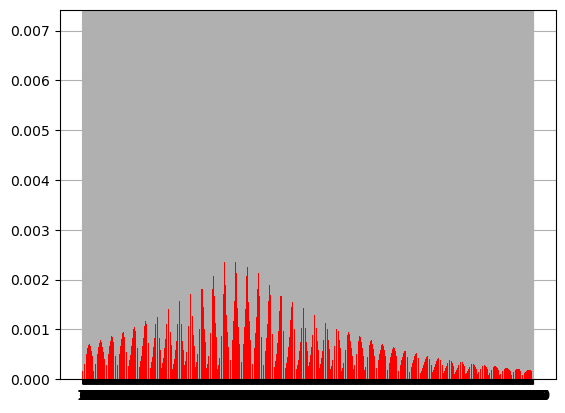

In [34]:
plot_beliefs(C[0])

### C[1] - Preference for color observations

In [35]:
# white, red, green <- order it's encoded in

In [36]:
# Set preferences for color observations
C[1] = np.zeros((num_obs[1],))
C[1][0] = -0.1
C[1][1] = -1
C[1][2] = 1.1

print(C[1])


[-0.1 -1.   1.1]


## D Vectors: Prior beliefs about hidden states

### Initialize

In [37]:
# Shape
num_states

[1600, 3]

In [38]:
D = utils.obj_array_uniform(num_states)

### D[0] - Belief About Current Location

In [39]:
# Define prior belief about agent's location (same as before)
D[0] = np.zeros(num_states[0])  # Shape (35,)
D[0][grid_locations.index(agent_pos)] = 1.0  # One-hot encoding for location

print("D[0] shape (Location prior):", D[0].shape)  # (35,)
D[0]

D[0] shape (Location prior): (1600,)


array([0., 0., 0., ..., 0., 0., 0.])

In [40]:
# # Initialize uniform distribution over locations
# D[0] = np.ones(num_states[0]) / num_states[0]  # Create normalized uniform distribution over all locations

# D[0]

### D[1] - Belief About Attribute of Current Location

In [41]:
D[1] = np.ones(num_states[1]) / num_states[1]  # Create normalized uniform distribution over all locations
D[1].shape

(3,)

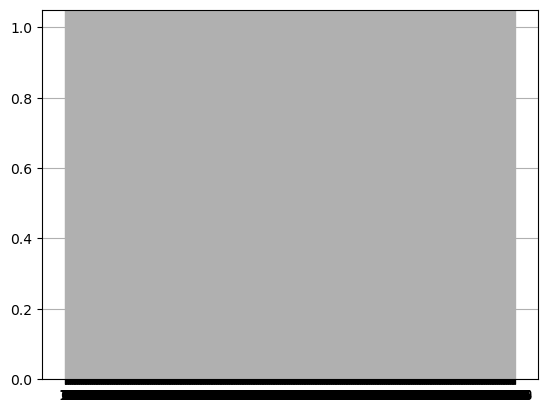

In [42]:
plot_beliefs(D[0])

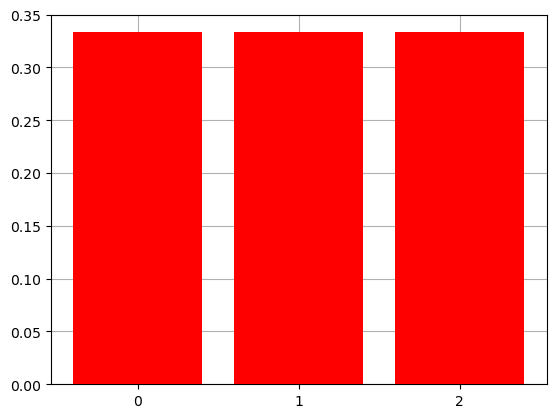

In [43]:
plot_beliefs(D[1])

# Generative Process

In [44]:
def update_vision(current_location, grid_dims, distance):
    """
    Update the agent's field of vision based on the current location and distance
    Returns a list of all grid positions within the vision range
    
    Args:
        current_location (tuple): Current (x,y) position of the agent
        grid_dims (list): Dimensions of the grid [width, height]
        distance (int): Vision range/distance
        
    Returns:
        list: List of (x,y) tuples representing visible grid positions
    """
    x, y = current_location
    x_min = max(0, x - distance)
    x_max = min(grid_dims[0], x + distance + 1)
    y_min = max(0, y - distance)
    y_max = min(grid_dims[1], y + distance + 1)
    
    visible_locations = []
    for y_pos in range(y_min, y_max):
        for x_pos in range(x_min, x_max):
            visible_locations.append((x_pos, y_pos))
            
    return visible_locations

In [45]:
X, Y = 0, 0

In [46]:
# class GridWorldEnv():
#     def __init__(self, starting_loc=(0, 0), redspots=[(1, 2), (3, 2), (4, 4), (6, 1)], goal=(6,4)):
#         # Initialize coordinates
#         self.x, self.y = starting_loc
#         self.init_loc = starting_loc
#         self.current_location = (self.x, self.y)

#         self.goal = goal

#         self.redspots = redspots

#         self.red_obs = ['Null']
#         self.green_obs = 'Null'
#         self.white_obs = ['Null']

#         self.agent_reward = 0
        
#         print(f"Starting location is {self.current_location} | Red spot locations are {self.redspots} | Goal is {self.goal}")
    
#     def step(self, action_label):
#         if action_label == "UP": 
#             self.y = max(0, self.y - 1)  # Move up (decrease y)
            
#         elif action_label == "DOWN": 
#             self.y = min(grid_dims[1] - 1, self.y + 1)  # Move down (increase y)

#         elif action_label == "LEFT": 
#             self.x = max(0, self.x - 1)  # Move left (decrease x)

#         elif action_label == "RIGHT": 
#             self.x = min(grid_dims[0] - 1, self.x + 1)  # Move right (increase x)

#         # Update current_location tuple after movement
#         self.current_location = (self.x, self.y)
#         print(f"self.current_location: {self.current_location}")
        
#         # Update vision with current coordinates
#         self.vision = update_vision(self.current_location, grid_dims, 6)

#         self.loc_obs = self.current_location

#         # Reset observations at each step
#         self.red_obs = ['Null']
#         self.white_obs = ['Null']
#         self.green_obs = 'Null'

#         # Update observations based on vision
#         for spot in self.vision:
#             if spot in self.redspots:
#                 if 'Null' in self.red_obs:
#                     self.red_obs = [spot]
#                 else:
#                     self.red_obs.append(spot)
#             elif spot == self.goal:
#                 self.green_obs = spot
#             else:
#                 if 'Null' in self.white_obs:
#                     self.white_obs = [spot]
#                 else:
#                     self.white_obs.append(spot)

#         # Update rewards and observations based on current location
#         if self.current_location in self.redspots:
#             self.agent_reward -= 5
#             if 'Null' in self.red_obs:
#                 self.red_obs = [self.current_location]
#             else:
#                 self.red_obs.append(self.current_location)
#         elif self.current_location == self.goal:
#             self.agent_reward += 20
#             self.green_obs = self.current_location
#         else:
#             if 'Null' in self.white_obs:
#                 self.white_obs = [self.current_location]
#             else:
#                 self.white_obs.append(self.current_location)
        
#         return self.loc_obs, self.green_obs, self.white_obs, self.red_obs, self.agent_reward
    
#     def reset(self):
#         self.x, self.y = self.init_loc
#         self.current_location = (self.x, self.y)
#         print(f'Re-initialized location to {self.current_location}')
#         self.loc_obs = self.current_location
#         self.green_obs, self.white_obs, self.red_obs, self.agent_reward = 'Null', ['Null'], ['Null'], 0

#         return self.loc_obs, self.green_obs, self.white_obs, self.red_obs, self.agent_reward

# Customizing Functions

In [47]:
def custom_get_expected_states(qs, B, policy, vision_matrix=vision_matrix):

    """

    Compute the expected states under a policy, also known as the posterior predictive density over states

    Parameters

    ----------

    qs: ``numpy.ndarray`` of dtype object

        Marginal posterior beliefs over hidden states at a given timepoint.

    B: ``numpy.ndarray`` of dtype object

        Dynamics likelihood mapping or 'transition model', mapping from hidden states at ``t`` to hidden states at ``t+1``, given some control state ``u``.

        Each element ``B[f]`` of this object array stores a 3-D tensor for hidden state factor ``f``, whose entries ``B[f][s, v, u]`` store the probability

        of hidden state level ``s`` at the current time, given hidden state level ``v`` and action ``u`` at the previous time.

    policy: 2D ``numpy.ndarray``

        Array that stores actions entailed by a policy over time. Shape is ``(num_timesteps, num_factors)`` where ``num_timesteps`` is the temporal

        depth of the policy and ``num_factors`` is the number of control factors.

    Returns

    -------

    qs_pi: ``list`` of ``numpy.ndarray`` of dtype object

        Predictive posterior beliefs over hidden states expected under the policy, where ``qs_pi[t]`` stores the beliefs about

        hidden states expected under the policy at time ``t``

    """

    n_steps = policy.shape[0]

    n_factors = policy.shape[1]

    # initialise posterior predictive density as a list of beliefs over time, including current posterior beliefs about hidden states as the first element

    qs_pi = [qs] + [utils.obj_array(n_factors) for t in range(n_steps)]

    

    # get expected states over time

    for t in range(n_steps):

        for control_factor, action in enumerate(policy[t,:]):

            qs_pi[t+1][control_factor] = B[control_factor][:,:,int(action)].dot(qs_pi[t][control_factor])

            qs_pi[t+1][1] = vision_matrix[qs_pi[t+1][0].argmax()]

            # # Debug visualization:
            # print(f"\n--- Debugging at timestep {t+1} and policy {policy[t,:]}")
            # print("Location beliefs:")
            # plot_beliefs(qs_pi[t+1][0], title_str=f"Location Beliefs - Step {t+1}")
            # print("Color beliefs:")
            # plot_beliefs(qs_pi[t+1][1], title_str=f"Color Beliefs - Step {t+1}")
            

    return qs_pi[1:]

In [48]:
from pymdp import control

# Inject our custom function
control.get_expected_states = custom_get_expected_states

# Active Inference

In [49]:
from pymdp.agent import Agent

## Create Observation

In [50]:
def create_color_observation(position, red_obs, green_obs, white_obs):

    if red_obs != ['Null']:
        if position in red_obs: return 1  # RED
    if green_obs == position: return 2 # GREEN
    elif white_obs != ['Null']:
        if position in white_obs: return 0 # WHITE
    return 3

In [51]:
def create_observation(position, red_obs, green_obs, white_obs):
    return [grid_locations.index(position), create_color_observation(position, red_obs, green_obs, white_obs)]

## Coppelia Environment + Gridworld

In [52]:
bubbleRobHandle = sim.getObject('/bubbleRob')

# Get BubbleRob's position
bubbleRob_position = get_object_position('bubbleRob')

# Create a control point with BubbleRob's x and y coordinates
# Format: [x, y, z, 0.0, 0.0, 0.0, 1.0] where x,y are from BubbleRob's position
ctrlPts = [[bubbleRob_position[0],bubbleRob_position[1],0.05,0.0,0.0,0.0,1.0]]                    
ctrlPts_flattened = [coord for point in ctrlPts for coord in point]



def monitor_position():
    pos1 = sim.getObjectPosition(bubbleRobHandle, -1)
    time.sleep(0.1)
    pos2 = sim.getObjectPosition(bubbleRobHandle, -1)
    print(f"Position change: {np.array(pos2) - np.array(pos1)}")
    


Coppelia position of bubbleRob: [0.25, 1.625, 0.12]


In [53]:
class CoppeliaEnv():
    def get_initial_object_properties(self):
        initial_pos = sim.getObjectPosition(self.bubbleRobHandle, -1)
        initial_orient = sim.getObjectQuaternion(self.bubbleRobHandle, -1)
        return initial_pos[2], initial_orient

    def __init__(self, redspots, starting_loc, goal):
        # Get robot handle first and ensure it's valid
        try:
            self.bubbleRobHandle = sim.getObject('/bubbleRob')
            if self.bubbleRobHandle == -1:
                raise Exception("Could not get handle to bubbleRob")
        except Exception as e:
            print(f"Error getting robot handle: {e}")
            raise

        # Initialize coordinates 
        self.x, self.y = starting_loc
        self.init_loc = starting_loc
        self.current_location = (self.x, self.y)
        self.goal = goal
        self.redspots = redspots

        # Initialize control points
        self.ctrlPts = ctrlPts  # Use external control points
        self.ctrlPts_flattened = ctrlPts_flattened

        # Initialize path-related variables
        self.initial_z, self.initial_orientation = self.get_initial_object_properties()
        self.posAlongPath = 0
        self.velocity = 0.08
        self.previousSimulationTime = sim.getSimulationTime()

    def bezier_recursive(self, ctrlPts, t):
        n = (len(ctrlPts) // 7) - 1
        point = np.zeros(3)
        total_weight = 0
        
        for i in range(n + 1):
            binomial_coeff = comb(n, i)
            weight = binomial_coeff * ((1 - t) ** (n - i)) * (t ** i)
            point_coords = np.array(ctrlPts[i * 7:i * 7 + 3])
            point += weight * point_coords
            total_weight += weight
        
        if total_weight > 0:
            point = point / total_weight
        
        point[2] = self.initial_z
        return point

    def calculate_total_length(self, ctrl_points, subdivisions=1000):
        total_length = 0.0
        prev_point = self.bezier_recursive(ctrl_points, 0)
        
        for i in range(1, subdivisions + 1):
            t = i / subdivisions
            curr_point = self.bezier_recursive(ctrl_points, t)
            total_length += np.linalg.norm(curr_point - prev_point)
            prev_point = curr_point
        return total_length

    def get_point_and_tangent(self, t, ctrl_points):
        point = self.bezier_recursive(ctrl_points, t)
        
        delta = 0.001
        t_next = min(1.0, t + delta)
        next_point = self.bezier_recursive(ctrl_points, t_next)
        
        tangent = next_point - point
        if np.linalg.norm(tangent) > 0:
            tangent = tangent / np.linalg.norm(tangent)
        
        return point, tangent

    def update_orientation(self, position, tangent):
        if np.linalg.norm(tangent[:2]) > 0:  # Only use X and Y components
            yaw = np.arctan2(tangent[1], tangent[0])
            orientation_quaternion = [0.0, 0.0, np.sin(yaw / 2), np.cos(yaw / 2)]
            sim.setObjectQuaternion(self.bubbleRobHandle, -1, orientation_quaternion)

    def follow_path(self):
        # Reset position along path for new path
        self.posAlongPath = 0
        
        # Calculate total length for current control points
        total_length = self.calculate_total_length(self.ctrlPts_flattened)
        self.previousSimulationTime = sim.getSimulationTime()
        
        while self.posAlongPath < total_length:
            t = sim.getSimulationTime()
            deltaT = t - self.previousSimulationTime
            
            if deltaT <= 0.0:
                self.previousSimulationTime = t
                continue
            
            self.posAlongPath += self.velocity * deltaT
            
            if self.posAlongPath >= total_length - 0.001:
                self.posAlongPath = total_length
                print("Reached the end of the path!")
                break
            
            # Calculate normalized parameter
            t_norm = np.clip(self.posAlongPath / total_length, 0, 1)
            # Get current position and tangent
            current_pos, tangent = self.get_point_and_tangent(t_norm, self.ctrlPts_flattened)
            
            # Ensure Z coordinate
            current_pos[2] = self.initial_z
            
            # Update position and orientation
            sim.setObjectPosition(self.bubbleRobHandle, -1, current_pos.tolist())
            self.update_orientation(current_pos, tangent)
            
            self.previousSimulationTime = t
            sim.step()
            time.sleep(0.05)

    def step(self, action_label):
        sim.startSimulation()
        
        # Store previous position before movement
        prev_x, prev_y = self.x, self.y
        offset_x = 0
        offset_y = 0
        # Basic movement logic
        if action_label == "UP":
            self.y = max(0, self.y - 1)
            # For UP/DOWN movement, offset the x coordinate
            offset_x = offset_x + 0.02  # Curve to the right
        elif action_label == "DOWN":
            self.y = min(grid_dims[1] - 1, self.y + 1)
            offset_x = offset_x - 0.02  # Curve to the left
        elif action_label == "LEFT":
            self.x = max(0, self.x - 1)
            offset_y = offset_y + 0.02  # Curve upward
        elif action_label == "RIGHT":
            self.x = min(grid_dims[0] - 1, self.x + 1)
            offset_y = offset_y - 0.02  # Curve downward

        # # Calculate midpoint with offset
        # midpoint_x = (self.ctrlPts[-1][0] + grid_to_coordinates(self.x, self.y)[0]) / 2 + offset_x
        # midpoint_y = (self.ctrlPts[-1][1] + grid_to_coordinates(self.x, self.y)[1]) / 2 + offset_y
        
        # # Add midpoint and endpoint
        # self.ctrlPts.append([midpoint_x, midpoint_y, 0.05, 0.0, 0.0, 0.0, 1.0])
        self.ctrlPts.append([grid_to_coordinates(self.x, self.y)[0], grid_to_coordinates(self.x, self.y)[1], 0.05, 0.0, 0.0, 0.0, 1.0])

        print(self.ctrlPts)
        # Update flattened control points
        self.ctrlPts_flattened = [coord for point in self.ctrlPts for coord in point]

        # Create path
        pathHandle = sim.createPath(
            self.ctrlPts_flattened,
            0,  # Options: open path
            100,  # Subdivision for smoothness
            0.5,  # No smoothness
            0,  # Orientation mode
            [0.0, 0.0, 1.0]  # Up vector
        )

        # Follow the path
        self.follow_path()
        
        # Update current location
        self.current_location = (self.x, self.y)
        
        # Clear control points for next step
        self.ctrlPts.clear()
        # Reset with current position
        self.ctrlPts.append([grid_to_coordinates(self.x, self.y)[0],
                            grid_to_coordinates(self.x, self.y)[1],
                            0.05, 0.0, 0.0, 0.0, 1.0])
        
        print(f"Current location: {self.current_location}")
        
        # Update vision with current coordinates
        self.vision = update_vision(self.current_location, grid_dims, 6)

        self.loc_obs = self.current_location

        # Reset observations at each step
        self.red_obs = ['Null']
        self.white_obs = ['Null']
        self.green_obs = 'Null'

        # Update observations based on vision
        for spot in self.vision:
            if spot in self.redspots:
                if 'Null' in self.red_obs:
                    self.red_obs = [spot]
                else:
                    self.red_obs.append(spot)
            elif spot == self.goal:
                self.green_obs = spot
                
            else:
                if 'Null' in self.white_obs:
                    self.white_obs = [spot]
                else:
                    self.white_obs.append(spot)

        # Update rewards and observations based on current location
        if self.current_location in self.redspots:
            self.agent_reward -= 5
            if 'Null' in self.red_obs:
                self.red_obs = [self.current_location]
            else:
                self.red_obs.append(self.current_location)
        elif self.current_location == self.goal:
            self.agent_reward += 20
            self.green_obs = self.current_location
        else:
            if 'Null' in self.white_obs:
                self.white_obs = [self.current_location]
            else:
                self.white_obs.append(self.current_location)
        
        return self.loc_obs, self.green_obs, self.white_obs, self.red_obs, self.agent_reward
    
    def reset(self):
        self.x, self.y = self.init_loc
        self.current_location = (self.x, self.y)
        print(f'Re-initialized location to {self.current_location}')
        self.loc_obs = self.current_location
        self.green_obs, self.white_obs, self.red_obs, self.agent_reward = 'Null', ['Null'], ['Null'], 0

        return self.loc_obs, self.green_obs, self.white_obs, self.red_obs, self.agent_reward
my_agent = Agent(A=A, B=B, C=C, D=D, policy_len=3)    
my_env = CoppeliaEnv(starting_loc = agent_pos, redspots=redspots, goal = goal_location)
loc_obs, green_obs, white_obs, red_obs, agent_reward = my_env.reset()
loc_obs, green_obs, white_obs, red_obs, agent_reward
loc_obs, green_obs, white_obs, red_obs, agent_reward = my_env.step('STAY')

Re-initialized location to (22, 33)
[[0.25, 1.625, 0.05, 0.0, 0.0, 0.0, 1.0], [0.25, 1.625, 0.05, 0.0, 0.0, 0.0, 1.0]]
Reached the end of the path!
Current location: (22, 33)


## Loop

In [ ]:
import csv
import math
import os
import datetime
from collections import Counter

def calculate_manhattan_distance(loc1, loc2):
    """Calculate Manhattan distance between two locations"""
    return abs(loc1[0] - loc2[0]) + abs(loc1[1] - loc2[1])

def calculate_shannon_entropy(distribution):
    """Calculate Shannon entropy of a distribution"""
    if not distribution:
        return 0
    
    total = sum(distribution.values())
    entropy = 0
    
    for count in distribution.values():
        probability = count / total
        entropy -= probability * math.log2(probability)
    
    return entropy

def save_metrics_to_csv(metrics, file_path=None):
    """Save metrics to a CSV file"""
    if file_path is None:
        # Create directory if it doesn't exist
        os.makedirs("results", exist_ok=True)
        file_path = f"results/results.csv"
        
    file_exists = os.path.isfile(file_path)
    
    # Ensure all fields are in the correct order and named correctly
    expected_fields = [
        "agent_type", "random_seed", "total_timesteps", "total_distance", 
        "goal_reached", "unique_locations", "revisited_locations", 
        "shannon_entropy", "grid_dims"
    ]
    
    # Create a new dictionary with fields in the expected order
    ordered_metrics = {field: metrics.get(field, "") for field in expected_fields}
    
    with open(file_path, 'a', newline='') as f:
        writer = csv.DictWriter(f, fieldnames=expected_fields)
        if not file_exists:
            writer.writeheader()
        writer.writerow(ordered_metrics)
    
    return file_path

# Initialize metrics tracking
random_seed = getattr(my_env, 'random_seed', None)  # Try to get random seed from environment
if random_seed is None:
    random_seed = "unknown"  # Default if not available

total_timesteps = 0
total_distance = 0
goal_reached = False
actions_taken = []

# Track state visits for entropy calculation
state_visits = Counter()
state_visits[tuple(loc_obs)] = 1  # Starting point already visited once

obs = create_observation(loc_obs, red_obs, green_obs, white_obs)
history_of_locs = [loc_obs]

for t in range(200):
    total_timesteps += 1
    
    obs = create_observation(loc_obs, red_obs, green_obs, white_obs)
    print(f"Observation: {obs}")
    vision_matrix = update_vision_matrix(vision_matrix, obs)

    # Update beliefs
    qs = my_agent.infer_states(obs)
    
    # Update obs matrix
    surrounding_locs = update_vision(loc_obs, grid_dims, 2)
    for loc in surrounding_locs:
        obs = create_observation(loc, red_obs, green_obs, white_obs)
        vision_matrix = update_vision_matrix(vision_matrix, obs)
        
    # Policy selection
    my_agent.infer_policies()
    chosen_action_id = my_agent.sample_action()
    
    movement_id = int(chosen_action_id[0])
    choice_action = actions[movement_id]
    print(f'Action at time {t}: {choice_action}')
    
    # Track action for analysis
    actions_taken.append(choice_action)
    
    # Previous location before step
    prev_loc = loc_obs[:]
    
    # Environment step
    loc_obs, green_obs, white_obs, red_obs, agent_reward = my_env.step(choice_action)
    
    # Calculate distance moved in this step
    step_distance = calculate_manhattan_distance(prev_loc, loc_obs)
    total_distance += step_distance
    
    # Track state visit for entropy calculation - increment counter for current location
    loc_tuple = tuple(loc_obs)
    state_visits[loc_tuple] += 1
    
    print(agent_reward, loc_obs, green_obs, white_obs, red_obs)
    history_of_locs.append(loc_obs)
    print(f'Grid location at time {t}: {loc_obs}')
    print(f'Reward at time {t}: {agent_reward}')
    print(f'Distance traveled so far: {total_distance}')
    print(f'Unique locations visited: {len(state_visits)}')
    print(f'Total visits: {sum(state_visits.values())}')
    print(f'Revisited locations: {sum(state_visits.values()) - len(state_visits)}')
    
    if loc_obs == goal_location:
        print(f"Goal reached at time {t}!")
        goal_reached = True
        break

print(f'Green observation at time {t}: {green_obs}')
print(f'White observation at time {t}: {white_obs}')
print("\n===== SIMULATION SUMMARY =====")
print(f"Total timesteps: {total_timesteps}")
print(f"Total distance traveled: {total_distance}")
print(f"Goal reached: {goal_reached}")
print(f"Unique locations visited: {len(state_visits)}")
print(f"Revisited locations: {sum(state_visits.values()) - len(state_visits)}")

# Calculate Shannon entropy based on state visits
shannon_entropy = calculate_shannon_entropy(state_visits)
print(f"Shannon entropy (state distribution): {shannon_entropy:.4f}")

# Show most visited locations
print("\nMost visited locations:")
for location, count in state_visits.most_common(5):
    print(f"  {location}: {count} visits")

# Save metrics to CSV with standardized field names
metrics = {
    "agent_type": "ActiveInference",
    "random_seed": trial_number,
    "total_timesteps": total_timesteps,
    "total_distance": total_distance,
    "goal_reached": 1 if goal_reached else 0,  # Convert boolean to int for CSV
    "unique_locations": len(state_visits),
    "revisited_locations": sum(state_visits.values()) - len(state_visits),
    "shannon_entropy": shannon_entropy,  # Changed from action_entropy to shannon_entropy
    "grid_dims": f"{grid_dims[0]}x{grid_dims[1]}"
}

csv_path = save_metrics_to_csv(metrics)
print(f"Results saved to {csv_path}")

Observation: [913, 0]
Action at time 0: LEFT
[[0.25, 1.625, 0.05, 0.0, 0.0, 0.0, 1.0], [0.125, 1.625, 0.05, 0.0, 0.0, 0.0, 1.0]]
Reached the end of the path!
Current location: (21, 33)
0 (21, 33) Null [(15, 27), (16, 27), (17, 27), (18, 27), (19, 27), (20, 27), (21, 27), (22, 27), (23, 27), (24, 27), (25, 27), (26, 27), (27, 27), (17, 28), (18, 28), (19, 28), (20, 28), (21, 28), (22, 28), (23, 28), (24, 28), (17, 29), (18, 29), (19, 29), (20, 29), (21, 29), (22, 29), (23, 29), (24, 29), (17, 30), (18, 30), (19, 30), (20, 30), (21, 30), (22, 30), (23, 30), (24, 30), (15, 31), (16, 31), (17, 31), (18, 31), (19, 31), (20, 31), (21, 31), (22, 31), (23, 31), (24, 31), (25, 31), (26, 31), (27, 31), (15, 32), (16, 32), (17, 32), (18, 32), (19, 32), (20, 32), (21, 32), (22, 32), (23, 32), (24, 32), (25, 32), (26, 32), (27, 32), (15, 33), (16, 33), (17, 33), (18, 33), (19, 33), (20, 33), (21, 33), (22, 33), (23, 33), (24, 33), (25, 33), (26, 33), (27, 33), (15, 34), (16, 34), (17, 34), (18, 34)

/var/folders/8p/pslxyyhj0qj4f30f0613clj40000gq/T/ipykernel_75473/493642392.py:155: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(hspace=0.4)


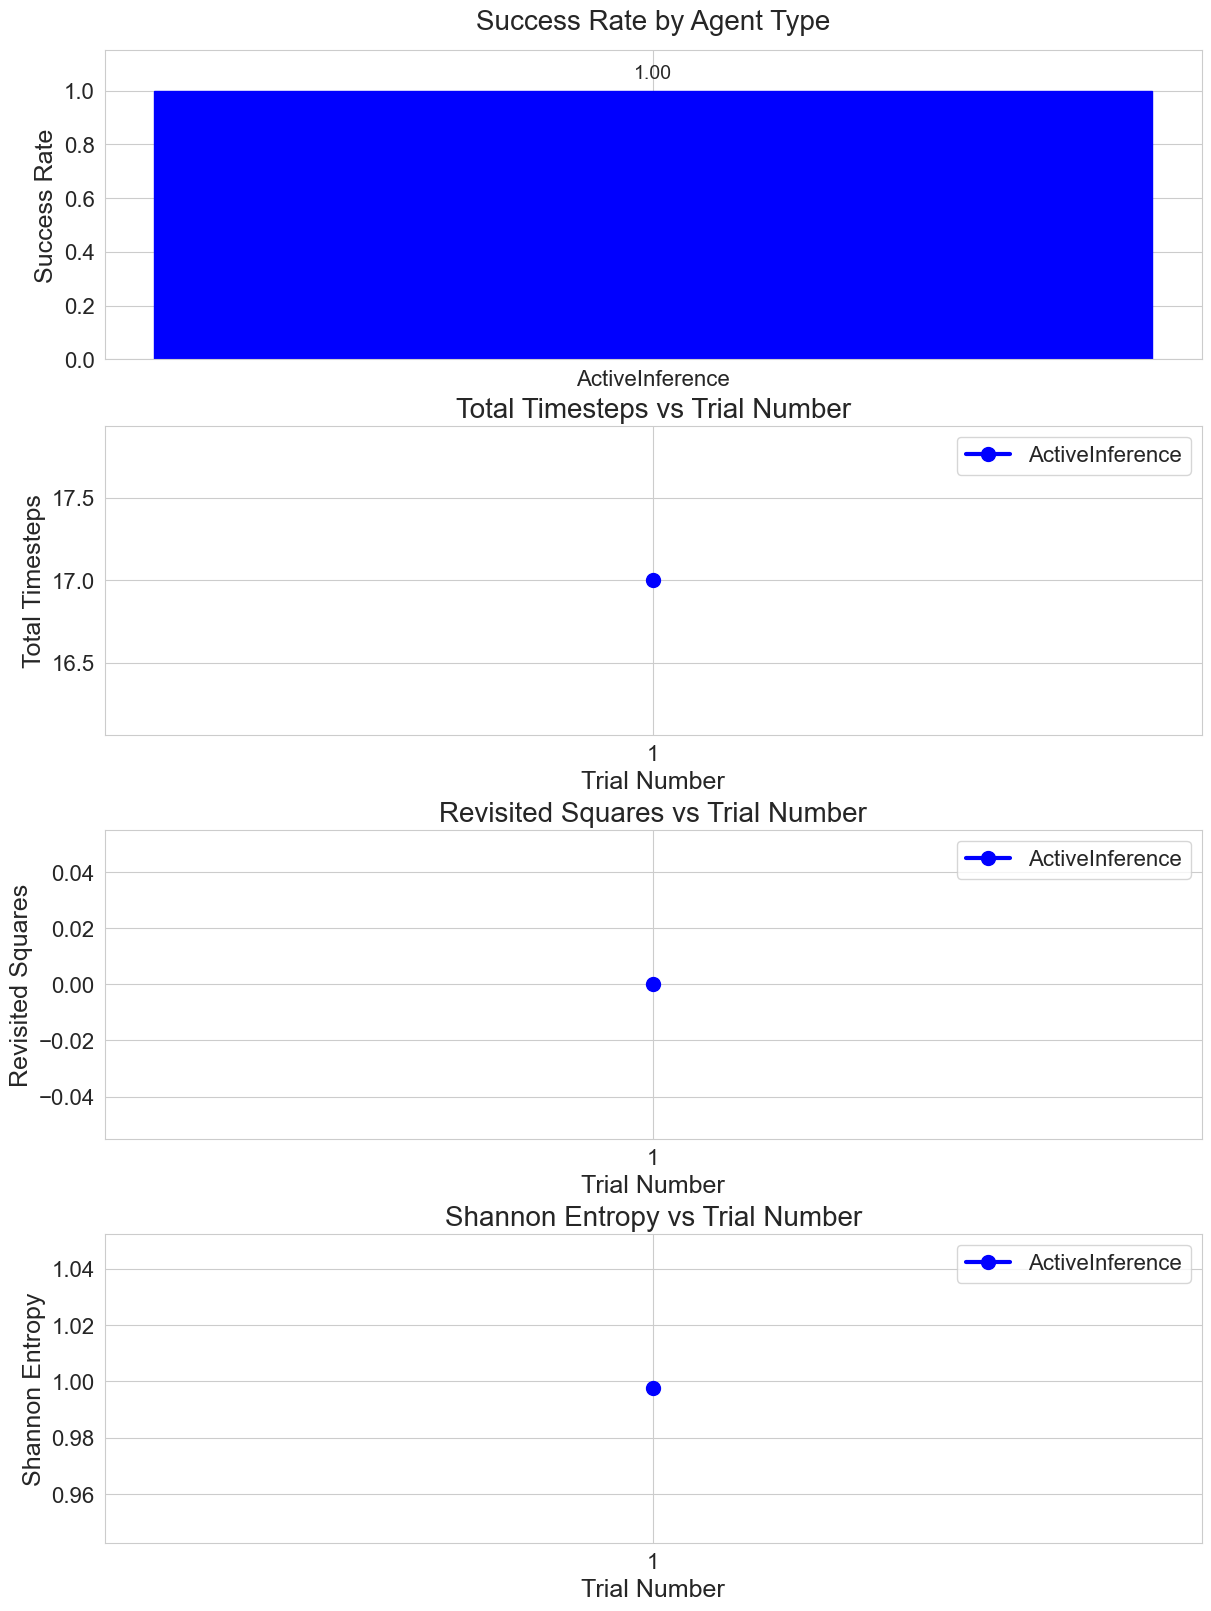

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import glob
import os
import seaborn as sns

def plot_agent_comparisons(csv_paths=None, figsize=(12, 16)):
    """
    Create specific comparison plots for agent performance with larger text and lines.
    Plots:
    1. Success Rate (bar chart)
    2. Timesteps vs Trial Number (line chart)
    3. Revisited Squares vs Trial Number (line chart)  
    4. Shannon Entropy vs Trial Number (line chart)
    
    Args:
        csv_paths: List of paths to CSV files or a directory path to search for CSVs.
        figsize: Figure size for the overall plot grid
    """
    # If no paths specified, find all CSVs in the results directory
    if csv_paths is None:
        csv_paths = glob.glob("results/active_inference_results_*.csv")
        dqn_files = glob.glob("../New_RL/comparison_results/dqn_results_*.csv")
        if dqn_files:
            csv_paths.extend(dqn_files)
    elif os.path.isdir(csv_paths):
        csv_paths = glob.glob(os.path.join(csv_paths, "*.csv"))
    elif isinstance(csv_paths, str):
        csv_paths = [csv_paths]
    
    # Load all CSV files into DataFrames
    dfs = []
    for path in csv_paths:
        try:
            df = pd.read_csv(path)
            dfs.append(df)
        except Exception as e:
            print(f"Error loading {path}: {e}")
    
    if not dfs:
        print("No data found to plot.")
        return
    
    # Combine all data
    data = pd.concat(dfs, ignore_index=True)
    
    # Create trial_number = 1, 2, 3... for each agent type
    # This ensures each agent type gets numbered 1, 2, 3... separately
    data = data.sort_values('random_seed')  # First sort by random_seed
    for agent in data['agent_type'].unique():
        # For each agent type, assign sequential trial numbers 1, 2, 3...
        mask = data['agent_type'] == agent
        data.loc[mask, 'trial_number'] = range(1, sum(mask) + 1)
    
    # Set up plot style with larger text and lines
    plt.rcParams.update({
        'font.size': 16,
        'axes.titlesize': 20,
        'axes.labelsize': 18,
        'xtick.labelsize': 16,
        'ytick.labelsize': 16,
        'legend.fontsize': 16,
        'lines.linewidth': 3,
        'lines.markersize': 10,
    })
    sns.set_style("whitegrid")
    
    # Define colors for agent types
    agent_colors = {'ActiveInference': 'blue', 'DQN': 'orange'}
    
    # Create figure with 4 subplots
    fig, axs = plt.subplots(4, 1, figsize=figsize, constrained_layout=True)
    
    # 1. Success Rate by Agent Type (Bar Chart)
    if 'agent_type' in data.columns and 'goal_reached' in data.columns:
        success_by_agent = data.groupby('agent_type')['goal_reached'].mean().reset_index()
        
        # Custom bar plot with specified colors
        bars = axs[0].bar(success_by_agent['agent_type'], success_by_agent['goal_reached'])
        
        # Set bar colors based on agent type
        for i, bar in enumerate(bars):
            agent_type = success_by_agent.iloc[i]['agent_type']
            bar.set_color(agent_colors.get(agent_type, 'gray'))
        
        # Place title with proper spacing
        axs[0].set_title('Success Rate by Agent Type', pad=15)
        axs[0].set_ylabel('Success Rate')
        axs[0].set_ylim(0, 1.15)  # Increase y limit to provide more space
        
        # Add value labels on bars with adjusted position
        for i, row in success_by_agent.iterrows():
            axs[0].text(i, row['goal_reached'] + 0.03, f"{row['goal_reached']:.2f}", 
                      ha='center', va='bottom', fontsize=14)  # Reduced font size for values
    else:
        axs[0].text(0.5, 0.5, "Missing data columns", ha='center', va='center')
    
    # 2. Timesteps vs Trial Number (Line Chart)
    if all(col in data.columns for col in ['trial_number', 'total_timesteps', 'agent_type']):
        for agent_type, color in agent_colors.items():
            agent_data = data[data['agent_type'] == agent_type]
            if not agent_data.empty:
                axs[1].plot(agent_data['trial_number'], agent_data['total_timesteps'], 
                          marker='o', color=color, label=agent_type)
        
        axs[1].set_title('Total Timesteps vs Trial Number')
        axs[1].set_xlabel('Trial Number')
        axs[1].set_ylabel('Total Timesteps')
        # Set x-axis to show integer values
        max_trial = data['trial_number'].max()
        axs[1].set_xticks(range(1, int(max_trial) + 1))
        axs[1].legend()
        axs[1].grid(True)
    else:
        axs[1].text(0.5, 0.5, "Missing data columns", ha='center', va='center')
    
    # 3. Revisited Squares vs Trial Number (Line Chart)
    if all(col in data.columns for col in ['trial_number', 'revisited_locations', 'agent_type']):
        for agent_type, color in agent_colors.items():
            agent_data = data[data['agent_type'] == agent_type]
            if not agent_data.empty:
                axs[2].plot(agent_data['trial_number'], agent_data['revisited_locations'], 
                          marker='o', color=color, label=agent_type)
        
        axs[2].set_title('Revisited Squares vs Trial Number')
        axs[2].set_xlabel('Trial Number')
        axs[2].set_ylabel('Revisited Squares')
        # Set x-axis to show integer values
        axs[2].set_xticks(range(1, int(max_trial) + 1))
        axs[2].legend()
        axs[2].grid(True)
    else:
        axs[2].text(0.5, 0.5, "Missing data columns", ha='center', va='center')
    
    # 4. Shannon Entropy vs Trial Number (Line Chart)
    if all(col in data.columns for col in ['trial_number', 'action_entropy', 'agent_type']):
        for agent_type, color in agent_colors.items():
            agent_data = data[data['agent_type'] == agent_type]
            if not agent_data.empty:
                axs[3].plot(agent_data['trial_number'], agent_data['action_entropy'], 
                          marker='o', color=color, label=agent_type)
        
        axs[3].set_title('Shannon Entropy vs Trial Number')
        axs[3].set_xlabel('Trial Number')
        axs[3].set_ylabel('Shannon Entropy')
        # Set x-axis to show integer values
        axs[3].set_xticks(range(1, int(max_trial) + 1))
        axs[3].legend()
        axs[3].grid(True)
    else:
        axs[3].text(0.5, 0.5, "Missing data columns", ha='center', va='center')
    
    # Add padding between subplots
    plt.subplots_adjust(hspace=0.4)
    
    # Save figure with high resolution
    plt.savefig('agent_comparison_plots.png', dpi=300, bbox_inches='tight')
    
    # Show plot
    plt.show()
    
    return data

# Run the visualization
if __name__ == "__main__":
    data = plot_agent_comparisons()

In [ ]:
# obs = create_observation(loc_obs, red_obs, green_obs, white_obs)
# history_of_locs = [loc_obs]

# for t in range(50):
#     obs = create_observation(loc_obs, red_obs, green_obs, white_obs)
#     print(f"Observation: {obs}")
#     vision_matrix = update_vision_matrix(vision_matrix, obs)

#     # Update beliefs
#     qs = my_agent.infer_states(obs)

#     # plot_beliefs(qs[0])
#     # plot_beliefs(qs[1])
    
#     # Update obs matrix
#     surrounding_locs = update_vision(loc_obs, grid_dims, 2)
#     for loc in surrounding_locs:
#         obs = create_observation(loc, red_obs, green_obs, white_obs)
#         vision_matrix = update_vision_matrix(vision_matrix, obs)
        
#     # visualize_vision_matrix(vision_matrix, grid_dims)
    
#     # Policy selection
#     my_agent.infer_policies()
#     chosen_action_id = my_agent.sample_action()
    
#     movement_id = int(chosen_action_id[0])
#     choice_action = actions[movement_id]
#     print(f'Action at time {t}: {choice_action}')
    
#     # Environment step
#     loc_obs, green_obs, white_obs, red_obs, agent_reward = my_env.step(choice_action)
    
#     print(agent_reward, loc_obs, green_obs, white_obs, red_obs)
#     history_of_locs.append(loc_obs)
#     print(f'Grid location at time {t}: {loc_obs}')
#     print(f'Reward at time {t}: {agent_reward}')
#     if my_env.current_location == goal_location:
#         print(f"Goal reached at time {t}!")
#         break
# print(f'Green observation at time {t}: {green_obs}')
# print(f'White observation at time {t}: {white_obs}')